# Cross-validation tutorial for time series data

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster, CrossValidator
from deep4cast.custom_losses import heteroscedastic_t
import deep4cast.topologies as topologies

from pandas import read_table

%matplotlib inline

Using TensorFlow backend.


# Data preparation

In [2]:
# Load the data from file
filename = '../data/energy.csv'
df = read_table(filename, sep=',')
df = df.head(2000)

# Prepare the data set
data = df[['load', 'temp']].astype('float32').values
data = np.expand_dims(data, axis=0)

# We just need a small holdout dataset for evaluation purposes
holdout = 24 # hours
train_data = data[:,:-holdout,[0]]
test_data = data[:,-holdout:,[0]]

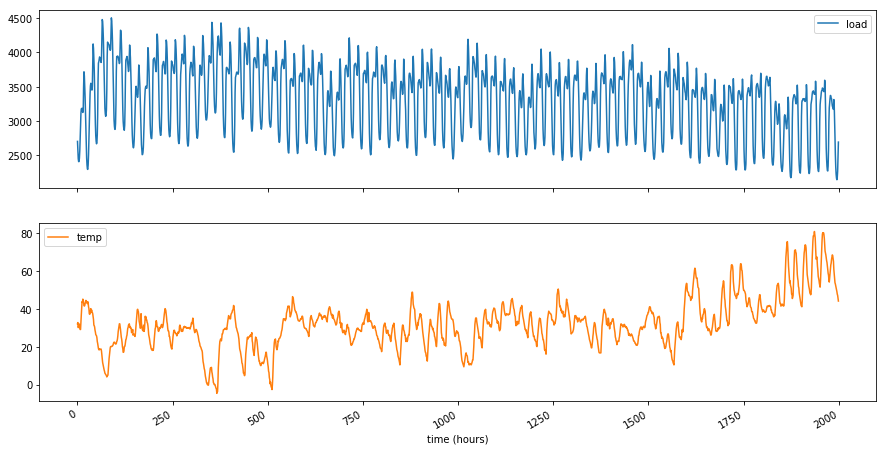

In [3]:
# Let plot the data
df.plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

# Modeling

In [4]:
topology = topologies.WaveNet(num_filters=32, num_layers=4)

In [11]:
forecaster = Forecaster(
    topology,
    lag=48,  # This is the number of time steps used to predict the future for each data point
    horizon=24,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=200,
    loss=heteroscedastic_t(vu=5, n_dim=2)
)

In [12]:
n_folds = 5
validator = CrossValidator(forecaster, val_fraction=0.05, n_folds=n_folds)

Training fraction is 0.75.


In [ ]:
metrics = validator.evaluate(data, n_samples=100)
metrics

Validation fold 0 took 91 s.


In [ ]:
# Plot calibration plots
x = [1, 5, 25, 50, 75, 95, 99]
coverages = metrics.iloc[:-2,-7:]
plt.figure(figsize=(6, 6))
plt.plot([0] + x + [100], [0] + x + [100], 'k-', linewidth=3)
for coverage in coverages.values:
    plt.plot(x, coverage, 'o-', alpha=0.2)
plt.plot(x, np.mean(coverages, axis=0), 'r-')
plt.legend([''] + ['fold ' + str(s) for s in np.arange(n_folds)])
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('Coverage plot')